<a href="https://colab.research.google.com/github/aleksandrast12/PUM_projekt_PZS/blob/Ola/Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

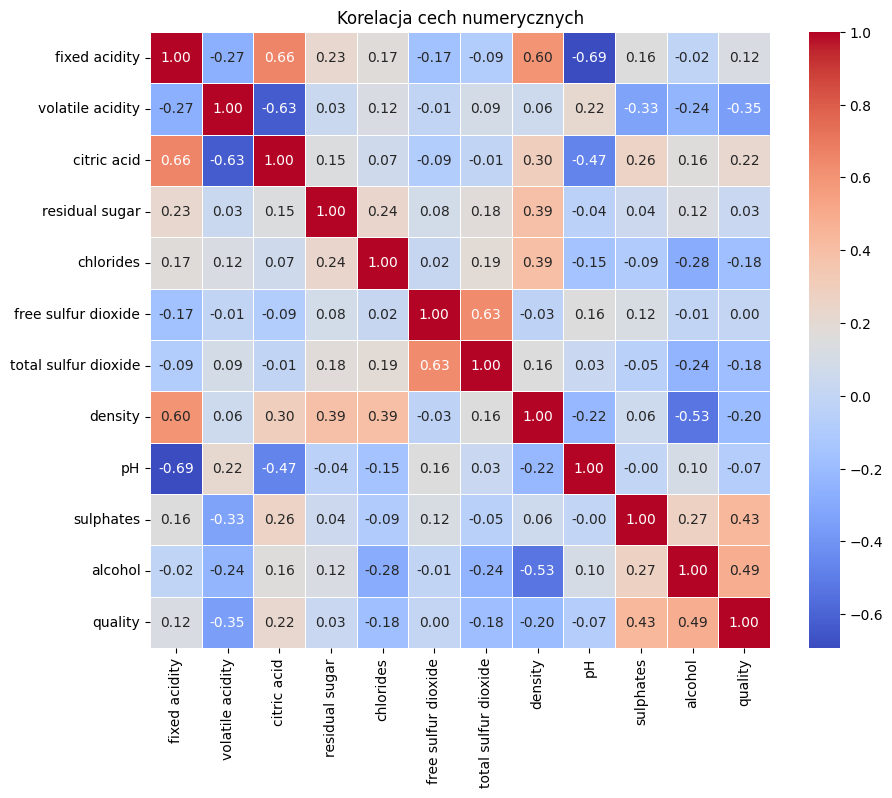

In [12]:

# y to quality

df = pd.read_csv("test.csv")

#df.drop_duplicates() - nie obowiazuje gdyz nawet przy jednym powtarzajacym sie elemencie inne cechy rozniace sie moga miec wplyw na ocene jakosci

#nie musimy usuwac kolumn
columns = ['fixed acidity',"volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol","quality"]
FeaturesToConvert = ['citric acid','residual sugar','chlorides']
for feature in FeaturesToConvert:
   df[feature] = df[feature].str.strip('-_')
for feature in FeaturesToConvert:
  df[feature] = df[feature].astype('float64')
for column in columns:
   df[column] = df[column].replace({'':np.nan})
#df.isna().sum()
df['density'] = df['density'].fillna(method='pad')

for column in  df[columns]:
  df[column]=np.abs(df[column])
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3- Q1
  df = df.drop(df.loc[df[column] > (Q3 + 1.5 * IQR)].index)
  df = df.drop(df.loc[df[column] < (Q1- 1.5 * IQR)].index)

scaler = preprocessing.StandardScaler().fit(df)
numerical_columns = df.select_dtypes(include=[float, int]).columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])



plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot = True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Korelacja cech numerycznych')
plt.show()









#df.info()
#df.head()

Pozostałe cechy: Index(['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')


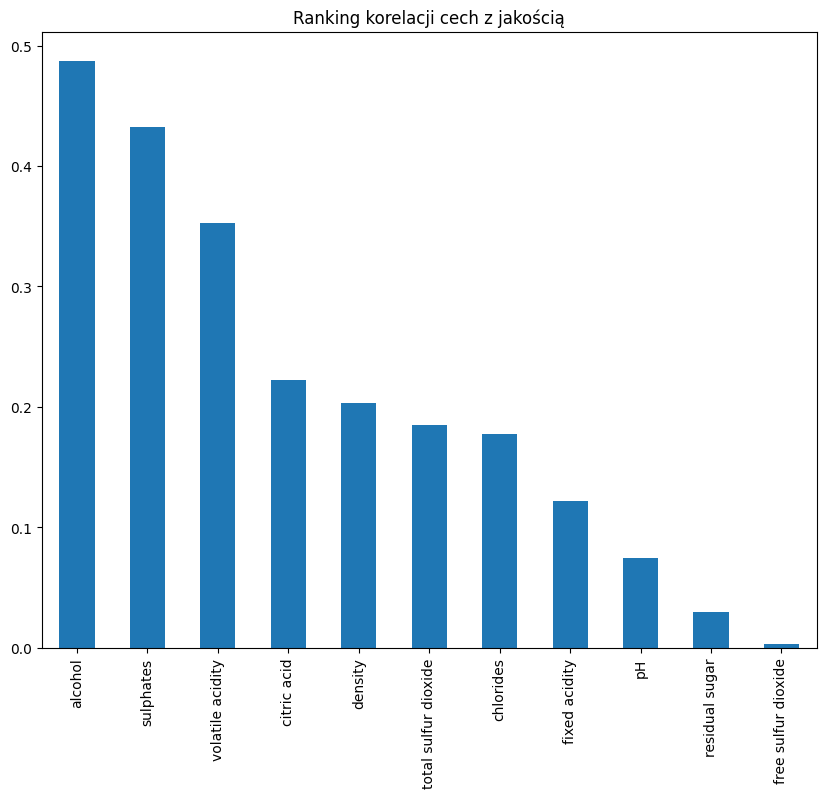

In [13]:
corr_quality = df.corr()['quality'].drop('quality').abs()
corr_quality_sort = corr_quality.sort_values(ascending=False)
corr_quality_sort.plot.bar(figsize=(10, 8))
plt.title('Ranking korelacji cech z jakością')
features_drop = corr_quality_sort.nsmallest(2).index
df_reduced = df.drop(columns=features_drop)

# wyświetlenie pozostałych cech
print("Pozostałe cechy:", df_reduced.columns)
plt.show()



Wyjaśniona wariancja [0.31285114 0.23666632 0.11634236 0.09516628 0.08108429 0.07084644
 0.05530114]


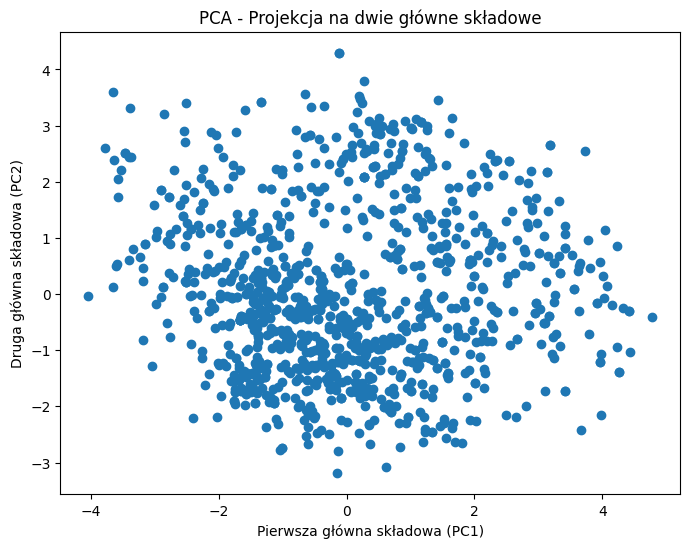

In [16]:

features = df_reduced.drop(columns=['quality'])
pca = PCA(n_components=0.95)  # zachowanie 95% wariancji
X_pca = pca.fit_transform(features)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Pierwsza główna składowa (PC1)')
plt.ylabel('Druga główna składowa (PC2)')
plt.title('PCA - Projekcja na dwie główne składowe')
print("Wyjaśniona wariancja", pca.explained_variance_ratio_)
plt.show()